In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Environment 🌎

### MLflow is a useful tool to track experiment results

cd to the root directory of this lesson (in my case `/Users/paulabartabajo/src/online-courses/hands-on-rl/03_cart_pole`) and spin up the mlflow tracking server as follows:

**$ mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0 --port 5000**

### 💡 if you have another service listening to port 5000, increase port number by 1 until you hit a free port.

In [2]:
try:
    import mlflow
    print("mlflow already installed")
except ImportError:
    !python -m pip install -q mlflow
    print("Installed mlflow")

# connect mlflow client to the mlflow server that runs on localhost:5000
MLFLOW_SERVER_URI = 'http://localhost:5000'

mlflow.set_tracking_uri(str(MLFLOW_SERVER_URI))

print("connected")

EXPERIMENT_NAME = 'hyperparameter_search'
mlflow.set_experiment(EXPERIMENT_NAME)
print("set")


mlflow already installed
connected
set


## Create an Optuna study

In [3]:
try:
    import optuna
    print("optuna already installed")
except ImportError:
    !python -m pip install -q optuna
    print("Installed optuna")

from src.config import OPTUNA_DB

study = optuna.create_study(
    study_name=EXPERIMENT_NAME,
    direction='maximize',
    load_if_exists=True,
    storage=f'sqlite:///{OPTUNA_DB}'
)

[I 2022-06-21 11:17:28,628] Using an existing study with name 'hyperparameter_search' instead of creating a new one.


optuna already installed


## Objective function we want to maximize

In [4]:
from src.optimize_hyperparameters import objective

# we define a lambda function because study.optimize()
# expect the objective function to have only 1 input
# (trial), while our objective function hast 2 extra
# inputs I defined to add flexibility to the script

from mlagents_envs.environment import UnityEnvironment
env_name = "TouchCube"
    
try:
    env.close()
except:
    pass

env = UnityEnvironment(file_name=env_name, no_graphics=True)
func = lambda trial: objective(trial,
                               force_linear_model=False,
                               n_episodes_to_train=100, 
                               env=env)

[INFO] Connected to Unity environment with package version 1.2.0-preview and communication version 1.0.0


INFO:mlagents_envs.environment:Connected to Unity environment with package version 1.2.0-preview and communication version 1.0.0


## Set threshold to terminate hyperparameter search

In [5]:
class CheckHyperparamMeanRewardThreshold:
    def __init__(self, reward_threshold: float):
        self.reward_threshold = reward_threshold

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if trial.value >= self.reward_threshold:
            print((f'Stopping hyperparameter search because trial.value ({trial.value}) '
                   f'hit threshold ({self.reward_threshold})'))
            study.stop()

# Stop hyperparameter search when we hit a perfect mean reward of mean_reward_to_stop
mean_reward_to_stop = 10
hyperparam_search_stop_callback = CheckHyperparamMeanRewardThreshold(mean_reward_to_stop)

## Let's start the search

In [ ]:
study.optimize(func, n_trials=50, callbacks=[hyperparam_search_stop_callback])

[INFO] Connected new brain: TouchCube?team=0


INFO:mlagents_envs.environment:Connected new brain: TouchCube?team=0


num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.2430497   0.          0.37310985  0.2430497  -0.83987963  0.37310985
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  0.005531029630396563


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.80 ep_mean_r -131.70 exploration 0.84          

[I 2022-06-21 11:34:46,842] Trial 51 finished with value: -213.16749999999996 and parameters: {'actor_learning_rate': 0.005531029630396563}. Best is trial 40 with value: -175.61399999999998.


mlflow loop, mean_reward =  -213.16749999999996 std_reward =  72.44535988419133
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.38193265  0.         -0.23113826  0.38193265 -0.83987963 -0.23113826
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  0.0009106622567695341


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.55 ep_mean_r -237.20 exploration 0.93          

[I 2022-06-21 11:50:26,811] Trial 52 finished with value: -183.19650000000004 and parameters: {'actor_learning_rate': 0.0009106622567695341}. Best is trial 40 with value: -175.61399999999998.


mlflow loop, mean_reward =  -183.19650000000004 std_reward =  62.690343456947176
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.44270054  0.          0.32488635  0.44270054 -0.83987963  0.32488635
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  0.0002790211316993253


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.75 ep_mean_r -154.00 exploration 0.94          

[I 2022-06-21 12:05:43,791] Trial 53 finished with value: -174.85300000000007 and parameters: {'actor_learning_rate': 0.0002790211316993253}. Best is trial 53 with value: -174.85300000000007.


mlflow loop, mean_reward =  -174.85300000000007 std_reward =  59.615513844971595
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.4715148   0.         -0.3998212   0.4715148  -0.83987963 -0.3998212
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  0.00020466076771742878


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.70 ep_mean_r -165.80 exploration 0.82          

[I 2022-06-21 12:24:42,254] Trial 54 finished with value: -227.935 and parameters: {'actor_learning_rate': 0.00020466076771742878}. Best is trial 53 with value: -174.85300000000007.


mlflow loop, mean_reward =  -227.935 std_reward =  107.72661521184075
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.6100899   0.          0.26829144  0.6100899  -0.83987963  0.26829144
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  0.0002736337877011417


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.80 ep_mean_r -137.90 exploration 0.95          

[I 2022-06-21 12:40:01,882] Trial 55 finished with value: -175.08750000000003 and parameters: {'actor_learning_rate': 0.0002736337877011417}. Best is trial 53 with value: -174.85300000000007.


mlflow loop, mean_reward =  -175.08750000000003 std_reward =  71.72473784371749
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.6741768   0.         -0.00610503 -0.6741768  -0.83987963 -0.00610503
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  0.00021091609129055127


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.65 ep_mean_r -229.80 exploration 0.94          

[I 2022-06-21 12:55:12,670] Trial 56 finished with value: -179.2895 and parameters: {'actor_learning_rate': 0.00021091609129055127}. Best is trial 53 with value: -174.85300000000007.


mlflow loop, mean_reward =  -179.2895 std_reward =  73.49037021780472
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.18213697  0.          0.56344146 -0.18213697 -0.83987963  0.56344146
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  0.0003355646816262674


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.70 ep_mean_r -185.85 exploration 0.97          

[I 2022-06-21 13:09:33,817] Trial 57 finished with value: -167.31149999999997 and parameters: {'actor_learning_rate': 0.0003355646816262674}. Best is trial 57 with value: -167.31149999999997.


mlflow loop, mean_reward =  -167.31149999999997 std_reward =  68.80917302765671
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.19101952  0.          0.38235655 -0.19101952 -0.83987963  0.38235655
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  0.0003491587752308361


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.45 ep_mean_r -291.15 exploration 0.91          

[I 2022-06-21 13:25:00,412] Trial 58 finished with value: -187.37450000000004 and parameters: {'actor_learning_rate': 0.0003491587752308361}. Best is trial 57 with value: -167.31149999999997.


mlflow loop, mean_reward =  -187.37450000000004 std_reward =  65.4547376035532
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.1077387   0.          0.6364179  -0.1077387  -0.83987963  0.6364179
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  7.117957790857018e-05


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.80 ep_mean_r -142.35 exploration 0.91          

[I 2022-06-21 13:40:23,119] Trial 59 finished with value: -183.17699999999994 and parameters: {'actor_learning_rate': 7.117957790857018e-05}. Best is trial 57 with value: -167.31149999999997.


mlflow loop, mean_reward =  -183.17699999999994 std_reward =  82.651597510272
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.38055745  0.         -0.16335629  0.38055745 -0.83987963 -0.16335629
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  0.0005214608375864011


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.65 ep_mean_r -232.55 exploration 0.91          

[I 2022-06-21 13:55:44,450] Trial 60 finished with value: -187.61849999999995 and parameters: {'actor_learning_rate': 0.0005214608375864011}. Best is trial 57 with value: -167.31149999999997.


mlflow loop, mean_reward =  -187.61849999999995 std_reward =  76.30591184665838
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.27829587  0.          0.33840284 -0.27829587 -0.83987963  0.33840284
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  0.0002539716975825071


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.60 ep_mean_r -218.80 exploration 0.89          

[I 2022-06-21 14:11:12,846] Trial 61 finished with value: -191.06849999999997 and parameters: {'actor_learning_rate': 0.0002539716975825071}. Best is trial 57 with value: -167.31149999999997.


mlflow loop, mean_reward =  -191.06849999999997 std_reward =  61.65985714182283
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.6254335   0.         -0.25006226  0.6254335  -0.83987963 -0.25006226
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  4.768250478144617e-05


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.70 ep_mean_r -173.85 exploration 0.93          

[I 2022-06-21 14:25:39,391] Trial 62 finished with value: -174.81649999999993 and parameters: {'actor_learning_rate': 4.768250478144617e-05}. Best is trial 57 with value: -167.31149999999997.


mlflow loop, mean_reward =  -174.81649999999993 std_reward =  71.79578924108293
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.47182754  0.          0.38717908 -0.47182754 -0.83987963  0.38717908
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  2.5694812048136855e-05


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.70 ep_mean_r -184.60 exploration 0.93          

[I 2022-06-21 14:40:25,287] Trial 63 finished with value: -180.46650000000002 and parameters: {'actor_learning_rate': 2.5694812048136855e-05}. Best is trial 57 with value: -167.31149999999997.


mlflow loop, mean_reward =  -180.46650000000002 std_reward =  86.18936768969826
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.5153826   0.         -0.08177549  0.5153826  -0.83987963 -0.08177549
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  3.404304539351578e-05


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.60 ep_mean_r -220.85 exploration 0.93          

[I 2022-06-21 14:55:18,370] Trial 64 finished with value: -177.215 and parameters: {'actor_learning_rate': 3.404304539351578e-05}. Best is trial 57 with value: -167.31149999999997.


mlflow loop, mean_reward =  -177.215 std_reward =  66.00963054736786
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.2589264   0.         -0.3139586   0.2589264  -0.83987963 -0.3139586
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  2.6593254048175317e-05


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.80 ep_mean_r -181.20 exploration 0.90          

[I 2022-06-21 15:11:12,143] Trial 65 finished with value: -190.23350000000002 and parameters: {'actor_learning_rate': 2.6593254048175317e-05}. Best is trial 57 with value: -167.31149999999997.


mlflow loop, mean_reward =  -190.23350000000002 std_reward =  85.08155060146706
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.19038628  0.         -0.40685657  0.19038628 -0.83987963 -0.40685657
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  1.6220882765958508e-05


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.75 ep_mean_r -143.35 exploration 0.91          

[I 2022-06-21 15:26:47,291] Trial 66 finished with value: -188.9265 and parameters: {'actor_learning_rate': 1.6220882765958508e-05}. Best is trial 57 with value: -167.31149999999997.


mlflow loop, mean_reward =  -188.9265 std_reward =  108.6128621423356
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.11129702  0.          0.4137336   0.11129702 -0.83987963  0.4137336
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  3.585314554608749e-05


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.60 ep_mean_r -215.50 exploration 0.88          

[I 2022-06-21 15:43:15,894] Trial 67 finished with value: -200.1015 and parameters: {'actor_learning_rate': 3.585314554608749e-05}. Best is trial 57 with value: -167.31149999999997.


mlflow loop, mean_reward =  -200.1015 std_reward =  98.74488504601136
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.14542964  0.         -0.6636734   0.14542964 -0.83987963 -0.6636734
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  3.9318599905737925e-05


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.75 ep_mean_r -174.00 exploration 0.68          

[I 2022-06-21 16:03:13,071] Trial 68 finished with value: -259.4405 and parameters: {'actor_learning_rate': 3.9318599905737925e-05}. Best is trial 57 with value: -167.31149999999997.


mlflow loop, mean_reward =  -259.4405 std_reward =  84.65306246527646
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.3308633   0.          0.3422182   0.3308633  -0.83987963  0.3422182
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  0.000103616396284228


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.75 ep_mean_r -158.15 exploration 0.92          

[I 2022-06-21 16:18:29,267] Trial 69 finished with value: -182.6295 and parameters: {'actor_learning_rate': 0.000103616396284228}. Best is trial 57 with value: -167.31149999999997.


mlflow loop, mean_reward =  -182.6295 std_reward =  63.18446094373205
num agents  1
action size  3
state size  21
Agent state looks like: 
[[-0.03521284  0.         -0.4182158  -0.03521284 -0.83987963 -0.4182158
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  6.371288553066468e-05


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.60 ep_mean_r -222.60 exploration 0.95          

[I 2022-06-21 16:33:19,464] Trial 70 finished with value: -173.53799999999998 and parameters: {'actor_learning_rate': 6.371288553066468e-05}. Best is trial 57 with value: -167.31149999999997.


mlflow loop, mean_reward =  -173.53799999999998 std_reward =  70.2586415040883
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.53813565  0.          0.4192072   0.53813565 -0.83987963  0.4192072
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  7.523781511530858e-05


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.60 ep_mean_r -215.35 exploration 0.92          

[I 2022-06-21 16:48:47,166] Trial 71 finished with value: -180.2055 and parameters: {'actor_learning_rate': 7.523781511530858e-05}. Best is trial 57 with value: -167.31149999999997.


mlflow loop, mean_reward =  -180.2055 std_reward =  65.71246224841983
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.37124732  0.         -0.57645994  0.37124732 -0.83987963 -0.57645994
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  0.00014192361943567416


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 100 success rate 0.85 ep_mean_r -135.70 exploration 0.93          

[I 2022-06-21 17:04:56,900] Trial 72 finished with value: -184.953 and parameters: {'actor_learning_rate': 0.00014192361943567416}. Best is trial 57 with value: -167.31149999999997.


mlflow loop, mean_reward =  -184.953 std_reward =  76.25073141288547
num agents  1
action size  3
state size  21
Agent state looks like: 
[[ 0.34357554  0.          0.22290821  0.34357554 -0.83987963  0.22290821
   0.          0.83987963  0.          0.          0.4048796   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]
PARAMS: actor_learning_rate =  0.00014455207864346505


D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:289: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Articulations Robot\Python Scripts and Build\src\optimize_hyperparameters.py:290: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
D:\Users\vika9\Unity Projects\Reinforcement-Learning\Unity Project Ar

epoch 35 success rate 0.70 ep_mean_r -197.15 exploration 2.55          

## These are the best hyper-parameters

In [7]:
best_trial = study.best_trial

hparams = {k: best_trial.params[k] for k in best_trial.params if k != 'seed'}
#hparams['nn_hidden_layers'] = eval(hparams['nn_hidden_layers']) 
print(hparams)

SEED = best_trial.params['seed']
print('Seed: ', SEED)

{'actor_learning_rate': 0.002507423476936172, 'critic_learning_rate': 0.0007230375967054082}


KeyError: 'seed'

## We can re-run the training to get the perfect agent

In [11]:
from src.utils import set_seed
set_seed(env, SEED)

from src.q_agent import QAgent
agent = QAgent(env, **hparams)

from src.loops import train
train(agent, env, n_episodes=200)

67,586 parameters


100%|█████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 15.12it/s]

Reward mean: 337.64, std: 29.49
Num steps mean: 337.64, std: 29.49


## or simply load the `agent_id` from the best run

In [3]:
from src.q_agent import QAgent
from src.config import SAVED_AGENTS_DIR

# you can find the agent_id for the best run in the MLflow
# dashboard.
# 298 is the value in my case, but you need to check what is your
agent_id = 298

path_to_saved_model = SAVED_AGENTS_DIR / 'CartPole-v1' / str(agent_id)
agent = QAgent.load_from_disk(env, path_to_saved_model)

67,586 parameters


## Evaluate the agent ⏱️

In [4]:
from src.loops import evaluate
rewards, steps = evaluate(
    agent, env,
    n_episodes=1000,
    epsilon=0.00
)

100%|███████████████████████████████████████████████████████████████████| 1000/1000 [03:00<00:00,  5.54it/s]


In [5]:
import numpy as np
reward_avg = np.array(rewards).mean()
reward_std = np.array(rewards).std()
print(f'Reward average {reward_avg:.2f}, std {reward_std:.2f}')

Reward average 500.00, std 0.00


## Let's see how far we got in each attempt

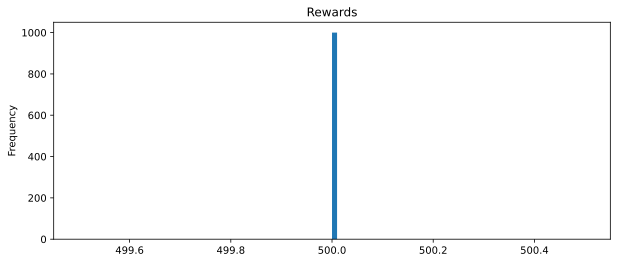

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Rewards")    
pd.Series(rewards).plot(kind='hist', bins=100)

plt.show()

## Let's see our agent in action 🎬

In [49]:
# Workaround for pygame error: "error: No available video device"
# See https://stackoverflow.com/questions/15933493/pygame-error-no-available-video-device?rq=1
# This is probably needed only for Linux
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

from src.viz import show_video

show_video(agent, env, sleep_sec=0.01, seed=123)